<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
K-means Clustering
</h1><br>

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Introduction
</h2><br>
Clustering is one of the most common exploratory data analysis technique used to get an intuition about the structure of the data. It can be defined as the task of identify subgroups in the data such that data points in the same cluster are very similar while data points in different cluster are very different. In other words, we try to find homogeneous subgroups within the data such that data points in each cluster are as similar as possible according to a similarity measure such as euclidean-based distance or or correlation-based distance. The decision of which similarity measure to use is an application-specific.

Clustering analysis can be done on the basis of features where were we try to find subgroups of samples based on features or on the basis of samples where we try to find subgroups of features based on samples. We'll cover here clustering based on features. Clustering can be found in many applications such as market segmentation where we try to fined customers that are similar to each other wither in terms of behavior or attributes and image compression where we try to group similar regions together to compress the image and save a lot of memory in both transmitting and storing the images.

Unlike supervised learning, clustering is considered an unsupervised learning method since we don't have the ground truth to compare the output of the clustering algorithm to to determine its performance. We only to try to investigate the structure of the data by grouping the data points into distinct groups.

In this notebook, we will cover only **Kmeans algorithm** which is considered as one of the main clustering algorithms due to its simplicity and computational efficiency. The notebook be broken into:
- [Kmeans Clustering](#kmeans)
- [Implementation](#implementation)
- [Application](#application)
    - [Image Compression](#imagecompression)
    - [profile segmentation](#2dexample)
- [Evaluation](#evaluation)
- [Drawbacks](#drawbacks)
- [Conclusion](#conclusion)

<a id='kmeans'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Kmeans Clustering
</h2><br>
Kmeans tries to make the inter-cluster data points as similar as possible while also keeping
the clusters as different (far) as possible.

**Kmeans** algorithm is an iterative algorithm that tries to partition the dataset into $K$ pre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to **only one group**. The objective is to assign data points to clusters and a set of centroids (center of each cluster) such that the sum of the squared distance (e.g sum of squared euclidean distance) between the data points and their cluster's centroids is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster. The centroid of cluster $k$ is the mean vector of all features over all the data points in the cluster:
$$\mu_k = \frac{1}{C_k}\sum_{i \in C_k}x^i$$
where ${C_k}$ is the set of data points that are assigned to centroid $k$. Therefore, centroids is a matrix with dimension $K\ x\ n$ and each data point is a vector in n-dimensional space.

The way Kmeans algorithm works is as follows:
1. Specify number of clusters $K$.
2. Initialize centroids by first shuffle the dataset and then randomly selecting $K$ data points for the centroids without replacement.
3. Keep iterating until there is no change to the centroids. i.e assignment of examples isn't changing.
    - Compute the sum of the squared distance between examples and all centroids.
    - Assign each example to the closest cluster (centroid).
    - Compute the centroids for the clusters by taking the average of the examples that belong to each cluster.

The objective function is:
$$\sum_{i = 1}^{m}\sum_{k = 1}^{K}r_{ik}\|x^i - \mu_k\|^2\\{}$$
where $r_{ik} = 1$ for data point $x^i$ if it belongs to cluster $k$; otherwise, $r_{ik} = 0$. Also, $\mu_k$ is the centroid of $x^i$'s data point cluster.

It's a minimization problem of two parts. We first minimize J w.r.t. $r_{ik}$ and treat $\mu_k$ fixed. Then we minimize J w.r.t. $\mu_k$ and treat $r_{ik}$ fixed. Mathematically speaking, we differentiate J w.r.t. $r_{ik}$ first and update cluster assignments. Then we differentiate J w.r.t. $\mu_{k}$ and recompute the centroids after the cluster assignments from previous step. Therefore,
$$\frac{\partial J}{\partial r_{ik}} = \sum_{i = 1}^{m}\sum_{k = 1}^{K}\|x^i - \mu_k\|^2\\{}$$
$$
\Rightarrow
\begin{equation}
  r_{ik} = \begin{cases}
    1 & \text{if $k = arg min_j\ \|x^i - \mu_j\|^2$}\\
    0 & \text{otherwise}.
  \end{cases}
\end{equation}\\{}
$$
In other words, assign the data point $x^i$ to the closest cluster judged by its distance from its centroid.
$$And\ \frac{\partial J}{\partial \mu_k} = 2\sum_{i = 1}^{m}r_{ik}(x^i - \mu_k) = 0\\{}$$
$$\Rightarrow \mu_k = \frac{\sum_{i = 1}^{m}r_{ik}x^i}{\sum_{i = 1}^{m}r_{ik}}$$
Which translates to recompute the centroid of each cluster to reflect the new assignments.

As a final note, since clustering algorithms including kmeans use distance-based measurements to determine the similarity between data points, it's recommended to standardize the data to have a mean of zero and a standard deviation of one since almost always the features in any data set would have different units of measurements such as age vs income.

Within-cluster variation is:
$$\frac{1}{m_k}\sum_{i = 1}^{m_k}\|x^i - \mu_{c^k}\|^2$$

<a id='implementation'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Implementation
</h2><br>
Given kmeans iterative nature and the random initialization of centroids at the start of the algorithm, different initializations may lead to different clusters since kmeans algorithm may *stuck in a local optimum and may not converge to global optimum*. Therefore, it's recommended to use run the algorithm using different initializations of centroids and pick the results of the run that that yielded the lower sum of squared distance. 

In [13]:
# Modules
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import pandas as pd
from scipy.io import loadmat
import seaborn as sns
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')

In [94]:
# Initialize centroids by assigning them to K training examples
def initialize_centroids(X, K):
    '''
    X: feature matrix m x n
    K: number of clusters
    Return: centroids vector K x n
    '''
    m = X.shape[0] # number of trainig examples
    # shuffle the index of the features without replacement
    random_index = np.random.permutation(m)
    
    return X[random_index[:K], :]


# Calculate the squared distance between examples & all centroids and assign each
# example to the closest centroid
def find_closest_centroids(X, centroids):
    '''
    X: feature matrix m x n
    centroids: clusters' means k x n
    Return: index of examples' clusters m x 1
    '''
    m = X.shape[0]
    K = centroids.shape[0]
    # initialize distance matrix
    distance = np.zeros((m, K))
    
    for i in range(K):
        distance[:, i] = np.sum(np.square(X - centroids[i, :]), axis=1)
    idx = np.argmin(distance, axis=1)

    return idx


# Calculate mean of each cluster (centroids)
def compute_centroids(X, idx, K):
    '''
    X: feature matrix m x n
    idx: index of examples' clusters
    K: number of clusters
    Return: centroids vector K x n
    '''
    n = X.shape[1]
    centroids = np.zeros((K, n))
    
    for i in range(K):
        centroids[i, :] = np.mean(X[idx == i, :], axis=0)

    return centroids


# Define kmean algorithm
def kMeans(X, K, maxiter=10):
    '''
    X: feature matrix m x n
    K: number of clusters    
    maxiter: number of iterations the algorithm will go through 
    Return: centroids vector K x n and index vector m x 1
    '''
    # Initializes centroids vector
    centroids = initialize_centroids(X, K)

    for i in range(maxiter):
        # assign examples to clusters
        idx = find_closest_centroids(X, centroids)
        # compute the mean of each cluster
        centroids = compute_centroids(X, idx, K)
        
    # rerun idx to get the latest assignment using final centroids vector
    idx = find_closest_centroids(X, centroids)
    
    return centroids, idx

<a id='application'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Application
</h2><br>
kmeans algorithm is very popular and used in a variety of applications such as market segmentation, document clustering, image segmentation and image compression, etc. The goal usually when undergo a cluster analysis is either:
1. Get a meaningful intuition of the structure of the data we're dealing with.
2. Or we believe that there is different subgroups within the data and these subgroups have innate differences.

As a result, cluster analysis can be either the end goal or will be used in the downstream data modeling which is called cluster-then-predict where different models will be built for different subgroups if we believe there is a wide variation in the behaviors of different subgroups. An example of that is clustering cancer patients into different subgroups and build a model for each subgroup to predict the probability of the risk of having heart attach.

In this notebook, we'll apply clustering on two cases: Image compression.

<a id='2dexample'></a>
<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
K-means on 2D Dataset
</h2><br>
We'll first implement the K-means algorithm on 2D dataset and see how it works. The dataset has 300 examples and 2 features and we will try to find $k$ subgroups within those examples and group them accordingly. Therefore, we'll end with subgroups where each subgroup has examples that are more homogenous (similar) to each other than the rest of the examples.

We'll use a data set that has 272 observations and 2 features. The data covers the waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA. below is the description of the features:
- eruptions (float): Eruption time in minutes.
- waiting (int):  Waiting time to next eruption.

Let's plot the data first:

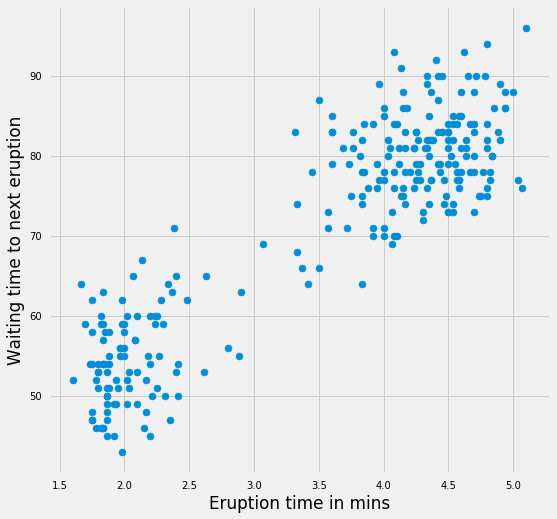

In [48]:
# Import the data
df = pd.read_csv('/Users/imad/Desktop/old_faithful.csv')
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1])
plt.xlabel('Eruption time in mins')
plt.ylabel('Waiting time to next eruption');

We'll use this data because it's easy to plot and visually spot the clusters since its a 2-dimension data set. Second, we can track the assignment of the kmeans algorithm for each data point into closest cluster and observe its convergence where no change in assignments can be made.

It's obvious that we have 2 clusters. Let's standardize the data first and run the kmeans algorithm on the standardized data with $K = 2$.

In [ ]:
# Standardize the data
X_std = StandardScaler().fit_transform(df)

# Run kmeans
km = KMeans(n_clusters=2,
            n_init=10,
            max_iter=300,
            tol=1e-4,
            random_state=123,
            n_jobs=-1)


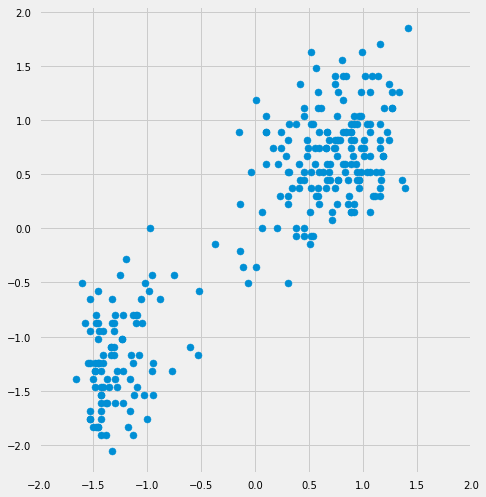

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(X_old[:, 0], X_old[:, 1])
plt.xlim([-2, 2])
plt.xlim([-2, 2])
ax.set_aspect('equal')

The above graph shows the scatter plot of the examples colored by the cluster they belong to. In this example, we chose $K = 3$ and it seems it's not bad. The symbol **'x'** is the centroid of each cluster. One of the most common applications of K-means clustering is *Market Segmentation*. We can think of those 3 clusters as different kinds of customers that behave similarly or have similar purchasing patterns. Therefore, we can target those customers using different types of promotions or ads.

<a id='imagecompression'></a>
<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Image Compression
</h2><br>
In this exercise, we'll implement Kmeans to image compression. The image that we'll be working on is 396 x 396 x 3. Therefore, for each pixel location we would have 3 8-bit integers that specify the red, green, and blue intensity values. Our goal is to reduce the number of colors to 30 and represent (compress) the photo using those 30 colors only. To pick which colors to use, we'll use K-means algorithm on the image and treat every pixel as an example. That means reshape the image from height x width x channels to (height * width) x channel, i,e we would have 396 x 396 = 156,816 data points in 3-dimensional space which are the intensity of RGB. Doing so will allow us to represent the image using the 30 centroids for each pixel and would significantly reduce the size of the image by a factor of 6. The original image size was 128 x 128 x 24 = 3,763,584 bits; however, the new compressed image would be 30 x 24 + 396 x 396 x 4 = 627,984 bits. The huge difference comes from the fact that we'll be using centroids as a lookup for pixels' colors and that would reduce the size of each pixel location to 4-bit instead of 8-bit.

In [64]:
396 * 396 * 24

3763584

In [65]:
627984 / 3763584

0.16685797367615549

In [61]:
30 * 24 + 396 * 396 * 4

627984

In [67]:
65920 / 393216

0.16764322916666666

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


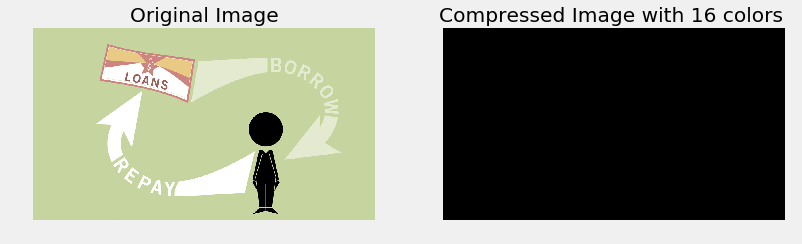

In [107]:
# Set the number of clusters and iterations the Kmeans algorithm will go through
K = 100; maxiter = 10

# Run the Kmeans algorithm and get the index of clusters for which each example
# belongs to as well as the final centroids vector
centroids, idx = kMeans(X, K, maxiter)

# Use the centroids colors as lookup for all examples
X_recovered = centroids[idx, :]

# Reshape X_recovered to have the same dimension as the original image 128 * 128 * 3
X_recovered = X_recovered.reshape(img_size[0], img_size[1], img_size[2])
# X_recovered = X_recovered.astype('uint8')

# Plot the original and the compressed image next to each other
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].imshow(A)
ax[0].set_title("Original Image")
ax[1].imshow(X_recovered)
ax[1].set_title("Compressed Image with 16 colors ")
for ax in fig.axes:
    ax.axis("off");

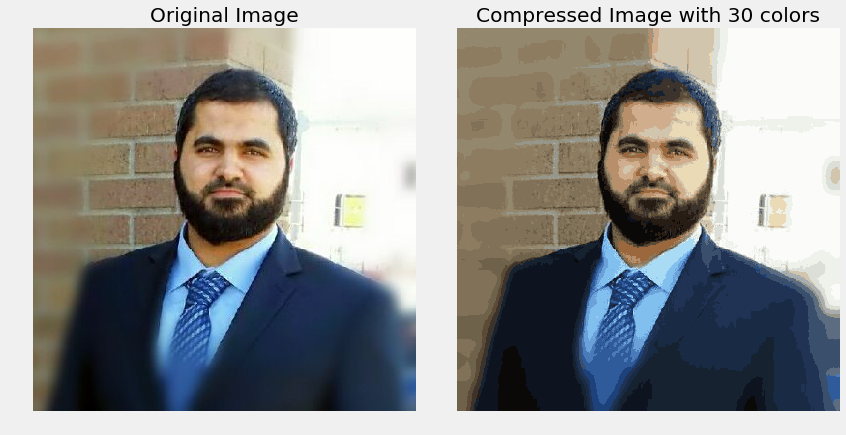

In [62]:
# Read the image
img = imread("images/my_image.jpg")
img_size = img.shape
# Reshape it to be 2-dimension
X = img.reshape(img_size[0] * img_size[1], img_size[2])


# Run the Kmeans algorithm and get the index of data points clusters
km = KMeans(n_clusters=30)
km.fit(X)

# Use the centroids colors as lookup for all examples
X_compressed = km.cluster_centers_[km.labels_]
X_compressed = np.clip(X_compressed.astype('uint8'), 0, 255)

# Reshape X_recovered to have the same dimension as the original image 128 * 128 * 3
X_compressed = X_compressed.reshape(img_size[0], img_size[1], img_size[2])

# Plot the original and the compressed image next to each other
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(X_compressed)
ax[1].set_title("Compressed Image with 30 colors")
for ax in fig.axes:
    ax.axis("off")
plt.tight_layout();

We can see the comparison between the original image and the compressed one. The compressed image looks very similar and close to the original one which means we're able to retain most of the characteristics of the original image. With smaller number of clusters we would have higher compression rate at the expense of image quality.

Note that this image compression method is called *lossy data compression* because we can't reconstruct the original image from the compressed image

<a id='evaluation'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Evaluation
</h2><br>
Contrary to supervised learning where we have the ground truth to evaluate the model's performance, clustering analysis doesn't have a solid evaluation metric that we can use to evaluate the outcome of different clustering algorithms. Therefore, there is no right answer in terms of the number of clusters that we should have in any problem. Sometimes domain knowledge and intuition may help but usually that is not the case. And in the cluster-predict methodology, we can evaluate how well the models are performing based on different $K$ clusters since clusters are used in the downstream modeling. However, in this notebook we'll cover two evaluation metrics:
- Elbow method
- Silhaust analysis

<a id='drawbacks'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Drawbacks
</h2><br>

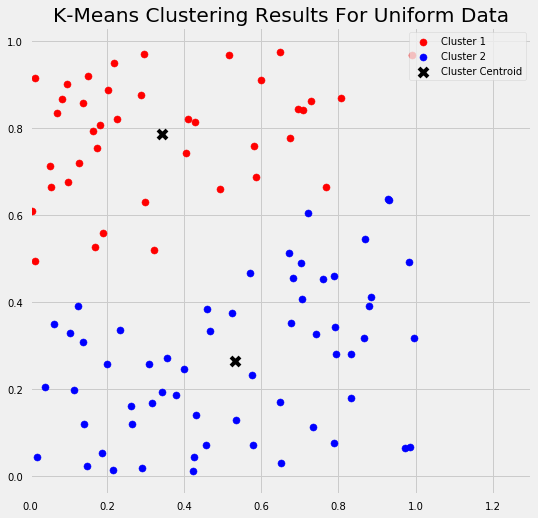

In [50]:
# Uniform
x1 = np.random.uniform(size=(100, 2))
k = 2
km = KMeans(n_clusters=2)
km.fit(x1)
labels = km.predict(x1)
centroids = km.cluster_centers_
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(x1[labels == 0, 0], x1[labels == 0, 1], s=50, c="red", label="Cluster 1")
plt.scatter(x1[labels == 1, 0], x1[labels == 1, 1], s=50, c="blue", label="Cluster 2")
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=80, c="k", label="Cluster Centroid")
plt.xlim([0, 1.3])
plt.legend(loc="upper right")
plt.title("K-Means Clustering Results For Uniform Data");

Kmeans algorithm doesn't let data points that are far-away from each other share the same cluster even though they obviously belong to the same cluster. Below is an example of data points on two different horizontal lines that illustrates how kmeans clusters half of the data points of each horizontal lines together. Therefore 

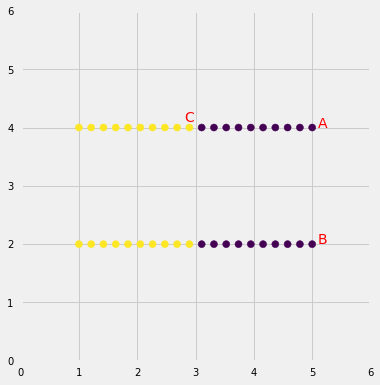

In [76]:
# Create horizantal data
X = np.tile(np.linspace(1, 5, 20), 2)
y = np.repeat(np.array([2, 4]), 20)
df = np.c_[X, y]

km = KMeans(n_clusters=2)
km.fit(df)
labels = km.predict(df)
centroids = km.cluster_centers_

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X, y, c=labels)
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.text(5.1, 4, 'A', color='red')
plt.text(5.1, 2, 'B', color='red')
plt.text(2.8, 4.1, 'C', color='red')
ax.set_aspect('equal')

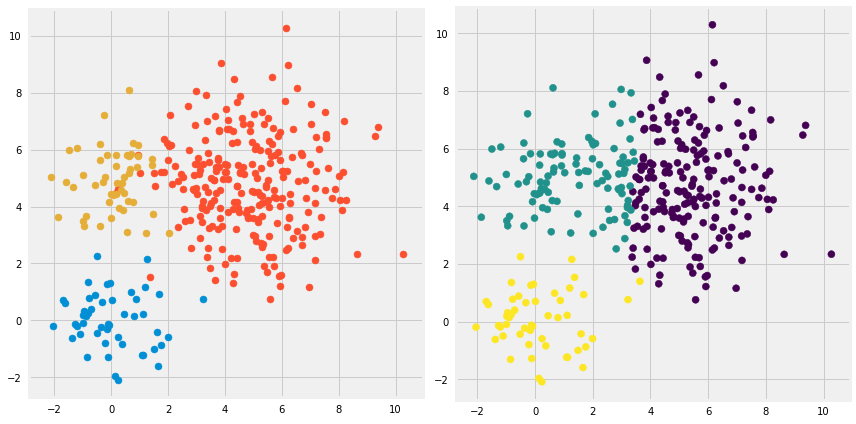

In [3]:
# Create data from three different multivariate distributions
X_1 = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=50)
X_2 = np.random.multivariate_normal(mean=[5, 5], cov=[[3, 0], [0, 3]], size=250)
X_3 = np.random.multivariate_normal(mean=[0, 5], cov=[[1, 0], [0, 1]], size=50)
df = np.concatenate([X_1, X_2, X_3])


km = KMeans(n_clusters=3)
km.fit(df)
labels = km.predict(df)
centroids = km.cluster_centers_

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[1].scatter(df[:, 0], df[:, 1], c=labels)
ax[1].set_aspect('equal')
ax[0].scatter(X_1[:, 0], X_1[:, 1])
ax[0].scatter(X_2[:, 0], X_2[:, 1])
ax[0].scatter(X_3[:, 0], X_3[:, 1])
ax[0].set_aspect('equal')
plt.tight_layout()

In [147]:
pd.value_counts(labels)

1    203
2     86
0     61
dtype: int64

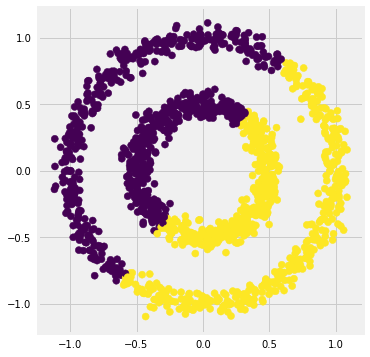

In [4]:
# Cricles
X = make_circles(factor=0.5, noise=0.05, n_samples=1500)

km = KMeans(n_clusters=2)
km.fit(X[0])
labels = km.predict(X[0])
centroids = km.cluster_centers_

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X[0][:, 0], X[0][:, 1], c=labels)
ax.set_aspect('equal')

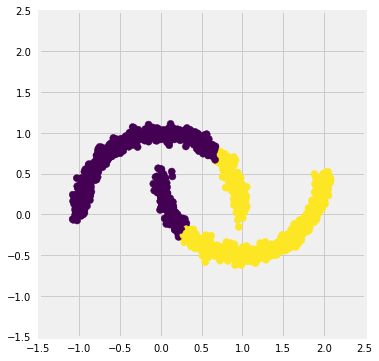

In [10]:
# Moons
X = make_moons(n_samples=1500, noise=0.05)

km = KMeans(n_clusters=2)
km.fit(X[0])
labels = km.predict(X[0])
centroids = km.cluster_centers_

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X[0][:, 0], X[0][:, 1], c=labels)
plt.xlim([-1.5, 2.5])
plt.ylim([-1.5, 2.5])
ax.set_aspect('equal')

<a id='conclusion'></a>
<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion
</h2><br>
Below are some takeaways:
* Scale the data when applying K-means algorithm
* Elbow method in selecting number of clusters doesn't usually work because the error function is monotonically decreasing for all $k$s
* If there is no example assigned to a cluster, we should eliminate it
* K-means gives more weight to the bigger cluster
* K-means assumes spherical shapes of clusters (with radius equal to the distance between the centroid and the furthest example) and doesn't work well when clusters are in different shapes such as elliptical clusters. Also, if there is overlapping between clusters, K-means doesn't have an intrinsic measure for uncertainty for the examples belong to the overlapping region in order to determine for which cluster to assign each example
* K-means may still cluster the data even if it can't be clustered such as data that comes from *uniform distributions*. See below: